In [1]:
%load_ext autoreload

import os, sys
import networkx as nx

sys.path.insert(0, "../")
sys.path.insert(0, "/home/j/joppich/.local/lib/python3.11/site-packages/")
print(sys.path)

%autoreload 2
from mikg.kgraph import *
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import leidenalg as la

from collections import defaultdict, Counter

import random
random.seed(42)

import pickle

['/home/j/joppich/.local/lib/python3.11/site-packages/', '../', '/mnt/raidbio/extproj/projekte/regulatory_networks/simulated_data', '', '/mnt/biosoft/software/python/3.11/lib/python3.11/site-packages', '/mnt/biosoft/software/python/3.11/lib64/python3.11/site-packages', '/usr/lib64/python311.zip', '/usr/lib64/python3.11', '/usr/lib64/python3.11/lib-dynload', '/home/j/joppich/.local/lib/python3.11/site-packages', '/usr/lib64/python3.11/site-packages', '/usr/lib64/python3.11/_import_failed', '/usr/lib/python3.11/site-packages']


In [2]:
kegg2reactome = {

    "REACTOME_PHENYLALANINE_AND_TYROSINE_METABOLISM": "R-HSA-8963691",
    "REACTOME_MITOCHONDRIAL_RNA_DEGRADATION": "R-HSA-9836573",
    "REACTOME_ATTACHMENT_OF_GPI_ANCHOR_TO_UPAR": "R-HSA-162791",
    "REACTOME_PHENYLALANINE_METABOLISM": "R-HSA-8964208",
    "REACTOME_GLYCOSPHINGOLIPID_BIOSYNTHESIS": "R-HSA-9840309",
    "REACTOME_PI5P_REGULATES_TP53_ACETYLATION": "R-HSA-6811555",
    "REACTOME_COBALAMIN_CBL_METABOLISM": "R-HSA-9759218",
    "REACTOME_APOBEC3G_MEDIATED_RESISTANCE_TO_HIV_1_INFECTION": "R-HSA-180689",
    "REACTOME_GLUTAMATE_AND_GLUTAMINE_METABOLISM": "R-HSA-8964539"

}

In [3]:
simulatedGenes = pd.read_csv("./simulated_changes_detail.tsv", sep="\t")
simulatedGenes["geneset"] = simulatedGenes.geneset.replace(kegg2reactome)
simulatedGenes

,wildtype,stage1,stage2,stage3,geneset,trend,element_type,gene
0,1,4,1,1,AMIT_EGF_RESPONSE_40_MCF10A,trend1,gene,ADM
1,1,4,1,1,AMIT_EGF_RESPONSE_40_MCF10A,trend1,gene,BUB1
2,1,4,1,1,AMIT_EGF_RESPONSE_40_MCF10A,trend1,gene,DUSP5
3,1,4,1,1,AMIT_EGF_RESPONSE_40_MCF10A,trend1,gene,EGR1
4,1,4,1,1,AMIT_EGF_RESPONSE_40_MCF10A,trend1,gene,EGR3
...,...,...,...,...,...,...,...,...
414,1,2,2,8,R-HSA-6811555,trend4,gene,TP53
415,1,2,2,8,R-HSA-6811555,trend4,tf,E2F1
416,1,2,2,8,R-HSA-6811555,trend4,tf,SP1
417,1,2,2,8,R-HSA-6811555,trend4,tf,STAT1


In [4]:
set(simulatedGenes["geneset"])

{'AMIT_EGF_RESPONSE_40_MCF10A',
 'BIOCARTA_ERBB3_PATHWAY',
 'BIOCARTA_FEEDER_PATHWAY',
 'BIOCARTA_IL22BP_PATHWAY',
 'BIOCARTA_RNAPOL3_PATHWAY',
 'BIOCARTA_SARS_PATHWAY',
 'BIOCARTA_SET_PATHWAY',
 'CAFFAREL_RESPONSE_TO_THC_8HR_5_UP',
 'DACOSTA_LOW_DOSE_UV_RESPONSE_VIA_ERCC3_XPCS_DN',
 'DASU_IL6_SIGNALING_DN',
 'FARDIN_HYPOXIA_9',
 'FINETTI_BREAST_CANCER_KINOME_RED',
 'GHO_ATF5_TARGETS_UP',
 'GREENBAUM_E2A_TARGETS_DN',
 'HEDENFALK_BREAST_CANCER_BRACX_UP',
 'IIZUKA_LIVER_CANCER_EARLY_RECURRENCE',
 'IIZUKA_LIVER_CANCER_PROGRESSION_G2_G3_DN',
 'IM_SREBF1A_TARGETS',
 'KEGG_MEDICUS_REFERENCE_AUTOPHAGY_VESICLE_NUCLEATION_ELONGATION_MATURATION_E3_UBIQUITIN_LIGASE_MALIN',
 'KEGG_MEDICUS_REFERENCE_COPII_VESICLE_FORMATION',
 'KEGG_MEDICUS_REFERENCE_II_BLOOD_GROUP_ANTIGEN_BIOSYNTHESIS',
 'KEGG_MEDICUS_REFERENCE_REGULATION_OF_GF_RTK_RAS_ERK_SIGNALING_MRAS_SHOC2_PP1_HOLOPHOSPHATASE',
 'KIM_GERMINAL_CENTER_T_HELPER_DN',
 'MCBRYAN_TERMINAL_END_BUD_DN',
 'MONTERO_THYROID_CANCER_POOR_SURVIVAL_DN',
 'MUNS

In [5]:
simulatedNetwork = pd.read_csv("./simulated_network.tsv", sep="\t", usecols=["TF", "gene"])
simulatedNetwork

,TF,gene
0,CEBPB,ADM
1,TP53,EGR1
2,NFATC2,EGR3
3,FOS,FOS
4,JUN,FOS
...,...,...
119,SP1,UGCG
120,EGR1,EP300
121,E2F1,PIN1
122,HMGA1,TP53


In [6]:
trend2gene = defaultdict(set)
trend2pathways = defaultdict(set)
pathways2genes = defaultdict(set)
gene2type = defaultdict(set)
gene2trends = defaultdict(set)

for ri, row in simulatedGenes.iterrows():

    trend2gene[row["trend"]].add(row["gene"])
    trend2pathways[row["trend"]].add(row["geneset"])
    pathways2genes[row["geneset"]].add(row["gene"])

    gene2type[row["gene"]].add(row["element_type"])
    gene2trends[row["gene"]].add(row["trend"])
    

In [7]:
for trend in trend2pathways:
    print(trend, len(trend2pathways[trend]), len(trend2gene[trend]))

trend1 10 141
trend2 10 100
trend3 10 89
trend4 10 79


In [8]:
stageSort = {
    "wildtype": 0,
    "stage1": 1,
    "stage2": 2,
    "stage3": 3
}

basedir = "comms"

In [9]:
kg = KGraph()
kg.load_kgraph("../data/initial_base_graph.out")

In [10]:
kg

KGraph KGraph with 111032 nodes and 1617389 edges

In [11]:
kg.get_edge_between_type()

Counter({('gene', 'geneset'): 841157,
         ('gene', 'gene'): 344408,
         ('TF;gene', 'gene'): 95771,
         ('geneset', 'geneset'): 74634,
         ('TF;gene', 'geneset'): 74544,
         ('gene', 'disease'): 43297,
         ('gene', 'geneset;subcellular_location'): 40554,
         ('disease', 'drug'): 35017,
         ('gene', 'TF;gene'): 19994,
         ('TF;gene', 'TF;gene'): 16120,
         ('gene', 'drug'): 7899,
         ('miRNA;ncRNA', 'gene'): 7848,
         ('TF;gene', 'disease'): 5105,
         ('TF;gene', 'miRNA;ncRNA'): 2099,
         ('TF;gene', 'geneset;subcellular_location'): 2043,
         ('miRNA;ncRNA', 'TF;gene'): 1808,
         ('gene', 'disease;geneset'): 1714,
         ('geneset;subcellular_location', 'geneset;subcellular_location'): 721,
         ('gene', 'miRNA;ncRNA'): 651,
         ('geneset;subcellular_location', 'geneset'): 460,
         ('gene;lncRNA;ncRNA', 'geneset'): 444,
         ('TF;gene', 'drug'): 341,
         ('geneset', 'disease;geneset'

In [12]:
containedEdges = 0
for ri, row in simulatedNetwork.iterrows():
    edgeContained = (row["TF"], row["gene"]) in kg.kg.edges
    if edgeContained:
        containedEdges += 1

    if not edgeContained:
        print(row["TF"], row["gene"], edgeContained)

print(containedEdges, ri+1, containedEdges/(ri+1))

FOS FOS False
JUN JUN False
TNFAIP3 JUN False
RBMX JUND False
ZFP36 VEGFA False
ZFP36L1 VEGFA False
RBMX JUNB False
SMAD4 PDGFRA False
APC SGK1 False
PER1 BAX False
IRF1 MAPK14 False
SERTAD1 SET False
TP53 TP53 False
111 124 0.8951612903225806


In [13]:
simNetwork = pd.read_csv("./simulated_network.tsv", sep="\t")
simNetwork.head()

,TF,gene
0,CEBPB,ADM
1,TP53,EGR1
2,NFATC2,EGR3
3,FOS,FOS
4,JUN,FOS


In [14]:
for ri, row in simNetwork.iterrows():
    et = (row["TF"], row["gene"])
    edge = et in kg.kg.edges
    edge_r = tuple(et[::-1]) in kg.kg.edges

    if not edge and not edge_r:
        print(et, edge, edge_r)
    

('FOS', 'FOS') False False
('JUN', 'JUN') False False
('RBMX', 'JUND') False False
('ZFP36', 'VEGFA') False False
('ZFP36L1', 'VEGFA') False False
('RBMX', 'JUNB') False False
('SMAD4', 'PDGFRA') False False
('APC', 'SGK1') False False
('PER1', 'BAX') False False
('IRF1', 'MAPK14') False False
('SERTAD1', 'SET') False False
('TP53', 'TP53') False False


In [15]:
exprDF = pd.read_csv("./expression_simulated_mean_df.tsv", sep="\t")

In [16]:
exprDF.head()

,group,gene,min,percentile_25,median,percentile_75,max,mean,num,sd,group_cells,perc_expr
0,stage1,A1BG,0.135103,0.299755,0.369649,0.448072,0.762750,0.381845,69,0.123641,5419,0.012733
1,stage1,A1BG.AS1,0.138112,0.319603,0.387099,0.479105,1.044375,0.404958,308,0.144913,5419,0.056837
2,stage1,A2M,0.119602,0.361211,0.468807,0.657032,2.089658,0.528361,746,0.244020,5419,0.137664
3,stage1,A2M.AS1,0.133371,0.304632,0.382526,0.477938,0.992434,0.397057,321,0.133843,5419,0.059236
4,stage1,A2ML1.AS1,0.119602,0.388011,0.509231,0.755049,2.050669,0.600180,747,0.296454,5419,0.137848


In [17]:
exprDFs = {}

for group in sorted(exprDF.group.unique(), key=lambda x: stageSort.get(x, -1)):
    exprDFs[group] = exprDF[exprDF.group == group].copy()

print([x for x in exprDFs])

['wildtype', 'stage1', 'stage2', 'stage3']


In [18]:
kg.get_node_types()

Counter({'geneset': 55163,
         'gene': 41990,
         'disease': 7781,
         'drug': 3195,
         'TF;gene': 1630,
         'miRNA;ncRNA': 593,
         'geneset;subcellular_location': 557,
         'disease;geneset': 61,
         'lncRNA;ncRNA': 36,
         'gene;lncRNA;ncRNA': 26})

In [19]:
kg.get_edge_types()

Counter({'part_of': 748950,
         'interacts': 434239,
         'relevant_in': 205461,
         'activates': 158390,
         'affected_by': 35051,
         'represses': 27058,
         'target_of': 8240})

In [20]:
exprKGs = {}

gsa = GenesetAnnotator()
mNS = MeanNetworkScorer()

for group in exprDFs:
    
    print(group)
    
    gKG = KGraph()
    
    gKG.load_kgraph("../data/initial_base_graph.out")

    gKG.add_gene_expression(exprDFs[group])
    mNS.score_nodes_from_properties(gKG)

    mNS.score(gKG)

    gsa.annotate_genesets(gKG, settype="disease", targettype="gene")
    gsa.annotate_genesets(gKG, settype="geneset", targettype="gene")
    gsa.annotate_genesets(gKG, settype="ncRNA", targettype="gene")
        
    exprKGs[group] = gKG

wildtype
Measured Genes 15099
Found Genes 14018


/mnt/raidbio/extproj/projekte/regulatory_networks/simulated_data/../mikg/kgraph.py:1607: RuntimeWarning: invalid value encountered in scalar divide
  edge_zscore = (edge_score-etype2mean[etype])/etype2std[etype]


Processed 7884 of 43646 target nodes for settype=disease and targettype=gene
Processed 42878 of 43646 target nodes for settype=geneset and targettype=gene
Processed 3390 of 43646 target nodes for settype=ncRNA and targettype=gene
stage1
Measured Genes 15099
Found Genes 14019
Processed 7884 of 43646 target nodes for settype=disease and targettype=gene
Processed 42878 of 43646 target nodes for settype=geneset and targettype=gene
Processed 3390 of 43646 target nodes for settype=ncRNA and targettype=gene
stage2
Measured Genes 15096
Found Genes 14015
Processed 7884 of 43646 target nodes for settype=disease and targettype=gene
Processed 42878 of 43646 target nodes for settype=geneset and targettype=gene
Processed 3390 of 43646 target nodes for settype=ncRNA and targettype=gene
stage3
Measured Genes 15094
Found Genes 14014
Processed 7884 of 43646 target nodes for settype=disease and targettype=gene
Processed 42878 of 43646 target nodes for settype=geneset and targettype=gene
Processed 3390 of

In [21]:
stage2trend = {
    "wildtype": "trend2",
    "stage1": "trend1",
    "stage2": "trend3",
    "stage3": "trend4"
}

In [22]:
DiffKG = DifferentialKG()

In [23]:
dkg = DiffKG.get_differential_graph(exprKGs["stage3"], exprKGs["stage2"])

/home/j/joppich/.local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:7030: RuntimeWarning: invalid value encountered in scalar divide
  svar = ((n1 - 1) * v1 + (n2 - 1) * v2) / df
/home/j/joppich/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/j/joppich/.local/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/j/joppich/.local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1103: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/home/j/joppich/.local/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1103: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


In [24]:
trend2pathways

defaultdict(set,
            {'trend1': {'AMIT_EGF_RESPONSE_40_MCF10A',
              'CAFFAREL_RESPONSE_TO_THC_8HR_5_UP',
              'DACOSTA_LOW_DOSE_UV_RESPONSE_VIA_ERCC3_XPCS_DN',
              'DASU_IL6_SIGNALING_DN',
              'FARDIN_HYPOXIA_9',
              'FINETTI_BREAST_CANCER_KINOME_RED',
              'GHO_ATF5_TARGETS_UP',
              'GREENBAUM_E2A_TARGETS_DN',
              'HEDENFALK_BREAST_CANCER_BRACX_UP',
              'IIZUKA_LIVER_CANCER_EARLY_RECURRENCE'},
             'trend2': {'IIZUKA_LIVER_CANCER_PROGRESSION_G2_G3_DN',
              'IM_SREBF1A_TARGETS',
              'KIM_GERMINAL_CENTER_T_HELPER_DN',
              'MCBRYAN_TERMINAL_END_BUD_DN',
              'MONTERO_THYROID_CANCER_POOR_SURVIVAL_DN',
              'MUNSHI_MULTIPLE_MYELOMA_DN',
              'PETRETTO_LEFT_VENTRICLE_MASS_QTL_CIS_DN',
              'RAMPON_ENRICHED_LEARNING_ENVIRONMENT_EARLY_DN',
              'STONER_ESOPHAGEAL_CARCINOGENESIS_DN',
              'TSUDA_ALVEOLAR_SOFT

Text(0.5, 1.0, 'Cumulative Histogram of Gene Fold Changes')

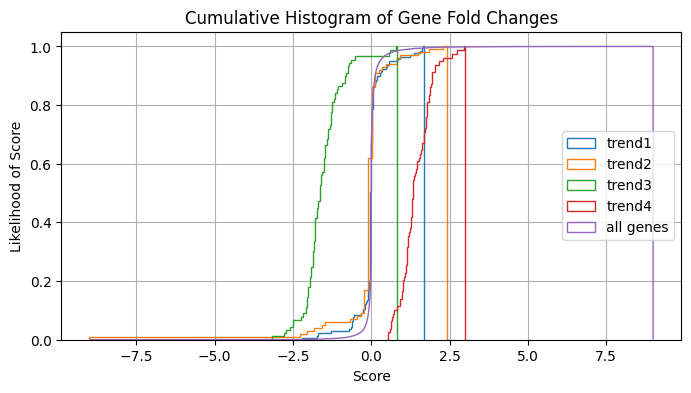

In [25]:
fig, ax = plt.subplots(figsize=(8, 4))
for trend in trend2gene:
    dkg.plot_node_attribute_histogram(attribute_accessor=lambda x: x["fc_score"], nodes=trend2gene[trend], ax=ax, title=trend)
dkg.plot_node_attribute_histogram(attribute_accessor=lambda x: x["fc_score"], ax=ax, title="all genes")
plt.title("Cumulative Histogram of Gene Fold Changes")

Text(0.5, 1.0, 'Cumulative Histogram of Pathway Fold Changes')

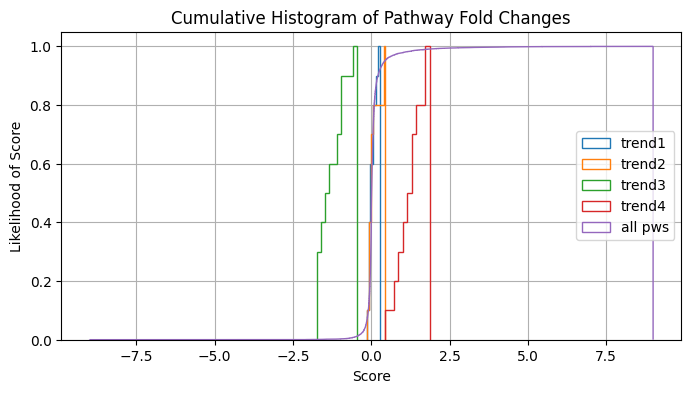

In [26]:
fig, ax = plt.subplots(figsize=(8, 4))
for trend in trend2gene:
    dkg.plot_node_attribute_histogram(attribute_accessor=lambda x: x["fc_score"], nodes=trend2pathways[trend], ax=ax, title=trend)
dkg.plot_node_attribute_histogram(node_type="geneset", attribute_accessor=lambda x: x["fc_score"], ax=ax, title="all pws")
plt.title("Cumulative Histogram of Pathway Fold Changes")

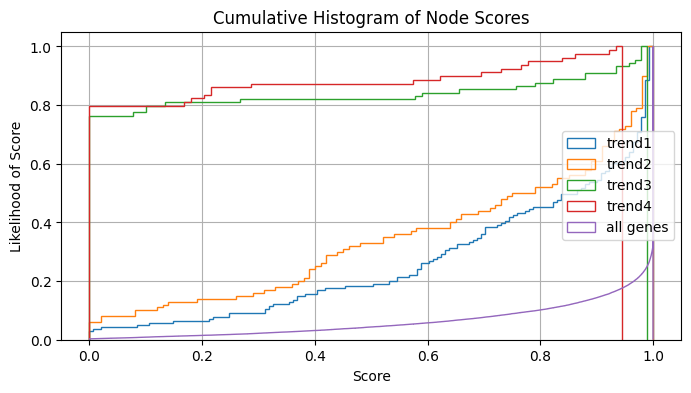

In [27]:
fig, ax = plt.subplots(figsize=(8, 4))
for trend in trend2gene:
    dkg.plot_node_attribute_histogram(attribute_accessor=lambda x: x["fc"]["sig"], nodes=trend2gene[trend], ax=ax, title=trend)
dkg.plot_node_attribute_histogram(attribute_accessor=lambda x: x["fc"]["sig"], ax=ax, title="all genes", node_type="gene")

In [28]:
def geneset_filter(n, kg):

    if kg.node_type_overlap(n, ["disease", "geneset"]):
        if len(kg._get_predecessors(n, ntype="gene")) < 5:
            return False

        if kg.kg.nodes[n]["fc"]["sig"] > 0.1:
            return False
   
    elif kg.node_type_overlap(n, ["gene"]):
        if kg.kg.nodes[n]["fc"]["sig"] > 0.9:
            return False

    else:
        #drug, ncRNA
        if kg.kg.nodes[n]["fc"]["sig"] > 0.9:
            return False

    
    return True

def filter_empty_genesets(n, kg):

    if kg.node_type_overlap(n, ["disease", "geneset"]):
        if len(kg._get_predecessors(n, ntype="gene")) < 3:
            return False

        numKgChildren = len(kg._get_predecessors(n, ntype="gene"))
        numAllChildren = len(dkg._get_predecessors(n, ntype="gene"))

        if (numKgChildren/numAllChildren) < 0.5:
            return False
    

    if kg.node_type_overlap(n, ["gene", "ncRNA"]):
        if len(kg.kg.edges(n)) == 0:
            return False

    return True

In [29]:
all_best_nodes = [x[0] for x in dkg.get_nodes_with_highest_scores(n=3000, score_accessor=lambda x: x["fc_score"], node_filter=geneset_filter)]

for bnodes in [100, 150, 200, 300, 400, 500, 750, 1000, 2000, 2500, 3000]:
    best_nodes = all_best_nodes[0:bnodes]
    for trend in trend2gene:
        trend_overlap = len(set(best_nodes).intersection(trend2gene[trend]))
        pw_overlap = len(set(best_nodes).intersection(trend2pathways[trend]))
        print(bnodes, trend, trend_overlap, trend_overlap/len(trend2gene[trend]), pw_overlap, pw_overlap/len(trend2pathways[trend]))

100 trend1 2 0.014184397163120567 0 0.0
100 trend2 1 0.01 0 0.0
100 trend3 0 0.0 0 0.0
100 trend4 57 0.7215189873417721 6 0.6
150 trend1 3 0.02127659574468085 0 0.0
150 trend2 2 0.02 0 0.0
150 trend3 1 0.011235955056179775 0 0.0
150 trend4 71 0.8987341772151899 9 0.9
200 trend1 4 0.028368794326241134 0 0.0
200 trend2 3 0.03 0 0.0
200 trend3 3 0.033707865168539325 0 0.0
200 trend4 77 0.9746835443037974 9 0.9
300 trend1 4 0.028368794326241134 0 0.0
300 trend2 3 0.03 0 0.0
300 trend3 3 0.033707865168539325 0 0.0
300 trend4 77 0.9746835443037974 9 0.9
400 trend1 4 0.028368794326241134 0 0.0
400 trend2 4 0.04 0 0.0
400 trend3 3 0.033707865168539325 0 0.0
400 trend4 77 0.9746835443037974 9 0.9
500 trend1 5 0.03546099290780142 0 0.0
500 trend2 4 0.04 0 0.0
500 trend3 3 0.033707865168539325 0 0.0
500 trend4 77 0.9746835443037974 9 0.9
750 trend1 6 0.0425531914893617 0 0.0
750 trend2 4 0.04 0 0.0
750 trend3 3 0.033707865168539325 0 0.0
750 trend4 77 0.9746835443037974 9 0.9
1000 trend1 6 0.0425

In [30]:
best_nodes = dkg.get_nodes_with_highest_scores(n=300, score_accessor=lambda x: x["fc_score"], node_filter=geneset_filter)       # nodetype="gene",
dkg_small = dkg.subset_kg([x[0] for x in best_nodes])
dkg_small

KGraph KGraph_vs_KGraph_subset with 300 nodes and 845 edges

In [64]:
[(xi, x) for xi, x in enumerate(best_nodes) if x[0] in ["R-HSA-9840309", "R-HSA-9840309"]]

[]

In [65]:
best_nodes[-1]

('RTN4', 0.27276932109811775)

In [32]:
len(set(dkg_small.kg.nodes).intersection(trend2gene["trend4"]))

77

In [33]:
dkg_filtered = dkg_small.filter_nodes(filter_empty_genesets)
dkg_filtered = dkg_filtered.filter_nodes(filter_empty_genesets)
dkg_filtered

KGraph KGraph_vs_KGraph_subset_filter_filter with 102 nodes and 430 edges

In [34]:
len(set(dkg_filtered.kg.nodes).intersection(trend2gene["trend4"]))

71

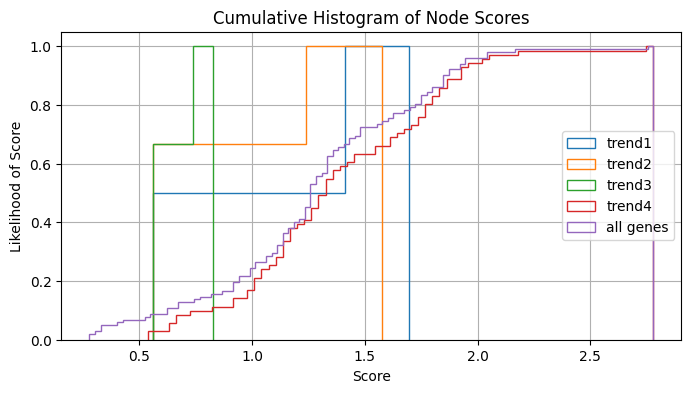

In [35]:
fig, ax = plt.subplots(figsize=(8, 4))
for trend in trend2gene:
    dkg_filtered.plot_node_attribute_histogram(attribute_accessor=lambda x: x["fc_score"], nodes=trend2gene[trend], ax=ax, title=trend)
dkg_filtered.plot_node_attribute_histogram(attribute_accessor=lambda x: x["fc_score"], ax=ax, title="all genes")


/mnt/biosoft/software/python/3.11/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


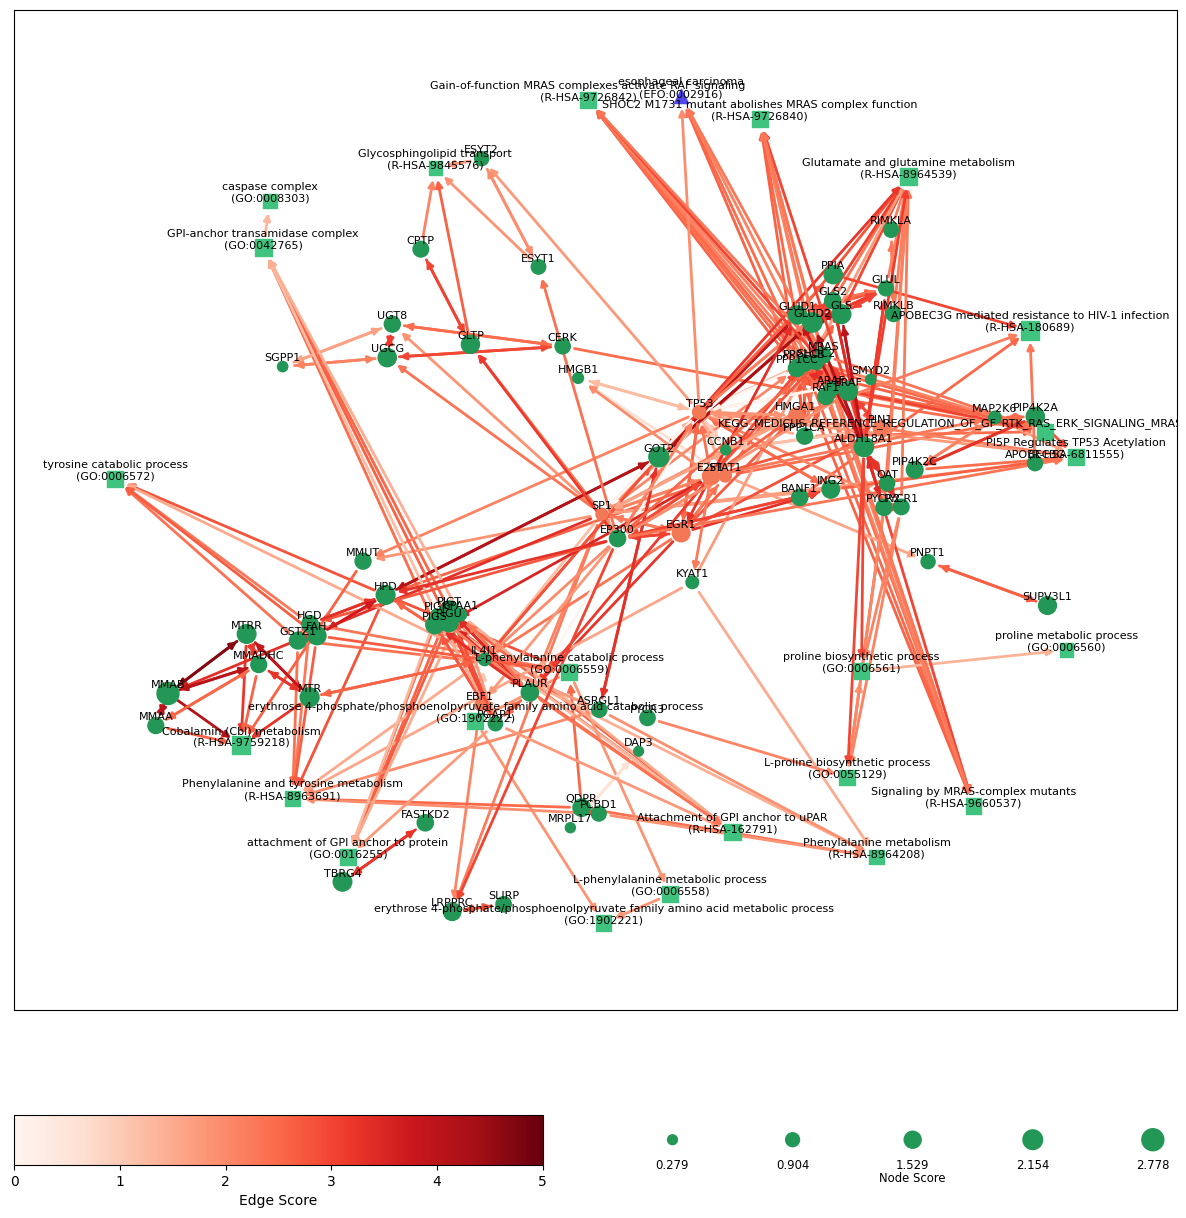

In [36]:
_=dkg_filtered.plot_graph(edge_score_accessor=lambda x: x.get("fc_score", 0), node_score_accessor=lambda x: x.get("fc_score", 0), figsize=(15, 15))

In [37]:
dkgModules = dkg_filtered.get_communities_greedymodularity(minEdgeScore=None, resolution=0.5, score_field="fc_score")
dkg_filtered.describe_communities(dkgModules)

Number of communities: 8
Average community size 12.75
Median community size 9.5
Quantile (0,0.25,0.5,0.75,1) community size [ 2.    3.5   9.5  19.75 30.  ]


In [38]:
def evaluate_communities(modules, target_trend, t2g, t2p, p2g):
    allTargetGenes = set()
    singleTargetGenes = set()

    foundPathways = set()

    for x in modules:
        if len(modules[x]) == 1:

            for y in modules[x]:
                if y in t2g[target_trend]:
                    singleTargetGenes.add(y)
            continue
        target_genes = set(modules[x]).intersection(t2g[target_trend])
        allTargetGenes.update(target_genes)

        if len(modules[x])> 0 and len(target_genes) > 0:
            intGenesets = set(t2p[target_trend]).intersection(modules[x])

            foundPathways.update(intGenesets)
            
            print(x, len(modules[x]), len(target_genes), target_genes, intGenesets)

            for pw in intGenesets:
                pwgenes = dkg_filtered._get_predecessors(pw, ntype="gene")
                print(pw, len(pwgenes), len(p2g.get(pw, [])), pwgenes.intersection(target_genes))
            print()

            for n in modules[x]:
                if n in intGenesets:
                    continue
                    
                if "geneset" in dkg_filtered.kg.nodes[n]["type"]:
                    pwgenes = dkg_filtered._get_predecessors(n, ntype="gene")
                    print("OTHER", n, len(pwgenes), pwgenes.intersection(target_genes))

            print()
            print()

    print(len(allTargetGenes))
    print(len(singleTargetGenes))
    print(len(foundPathways), t2p[target_trend].difference(foundPathways))

In [39]:
evaluate_communities(dkgModules, "trend1", trend2gene, trend2pathways, pathways2genes)

cc_0 30 4 {'EGR1', 'TP53', 'SP1', 'E2F1'} set()

OTHER GO:0042765 5 set()
OTHER GO:0016255 6 set()
OTHER R-HSA-162791 7 set()
OTHER R-HSA-6811555 7 {'TP53'}
OTHER R-HSA-180689 4 set()
OTHER GO:0008303 5 set()


4
0
0 {'DACOSTA_LOW_DOSE_UV_RESPONSE_VIA_ERCC3_XPCS_DN', 'CAFFAREL_RESPONSE_TO_THC_8HR_5_UP', 'HEDENFALK_BREAST_CANCER_BRACX_UP', 'GHO_ATF5_TARGETS_UP', 'IIZUKA_LIVER_CANCER_EARLY_RECURRENCE', 'GREENBAUM_E2A_TARGETS_DN', 'DASU_IL6_SIGNALING_DN', 'FARDIN_HYPOXIA_9', 'FINETTI_BREAST_CANCER_KINOME_RED', 'AMIT_EGF_RESPONSE_40_MCF10A'}


In [50]:
def evaluate_communities_detail(kg, modules, target_trend, t2g, t2p, p2g, g2t, fullKG=None, maxlen=30):

    fndElems = []
    for pw in t2p[target_trend]:

        unknownGenes = set()
        stage_counter = Counter()
        #for s,t in dkg.get_node_edges(pw):

        print(target_trend, pw, pw in kg.kg.nodes)
        if not fullKG is None:
            if not pw in kg.kg.nodes:
                print(fullKG.kg.nodes[pw])
        
        for s in p2g[pw]:
        
            cont_stages = set()
            for x in modules:
                if s in modules[x]:
                    cont_stages.add(x)

            inKG = s in kg.kg.nodes

            if not inKG:
                unknownGenes.add(s)
            
            print(target_trend, pw, s, g2t[s], inKG, cont_stages)
            if len(cont_stages) > 0:
                for x in cont_stages:
                    stage_counter[x] += 1
            else:
                stage_counter["NA"] += 1

        print(stage_counter)
        
        foundCount = sum([stage_counter[x] for x in stage_counter if not x == "NA"])
        notFoundCount = stage_counter["NA"]
        fndElems.append([pw, foundCount, notFoundCount])

        if not fullKG is None:
            for s in unknownGenes:
                print(s, fullKG.kg.nodes[s])
        
        print()

    print()
    print()

    pwSens = set()
    gSens = set()
    pw2sensitivity = defaultdict(set)
    
    for pw in t2p[target_trend]:

        if pw in kg.kg.nodes:
            pwSens.add(pw)

        for g in p2g[pw]:
            
            if g in kg.kg.nodes:
                pw2sensitivity[pw].add(g)
                gSens.add(g)

    pwSensitivity = len(pwSens) / len(t2p[target_trend])
    geneSensitivity = len(gSens) / len(t2g[target_trend])

    pwGeneSensitivity = {}
    for pw in t2p[target_trend]:
        pwGeneSensitivity[pw] = len(pw2sensitivity[pw]) / len(p2g[pw])


    print("Pathway Sensitivity", pwSensitivity)
    print("Gene Sensitivity", geneSensitivity)
    weightedSens = 0
    allGenes = 0
    for pw in pwGeneSensitivity:
        print("PW-Gene Sensitivity", pw, pwGeneSensitivity[pw])

        weightedSens += pwGeneSensitivity[pw] * len(p2g[pw])
        allGenes += len(p2g[pw])

    print("Weighted Sensitivity", weightedSens/allGenes)

    df = pd.DataFrame.from_records(fndElems, columns=["pathway", "found", "missing"])
    
    rid2name = {}
    for rpw in set(df.pathway):
        if rpw.startswith("R-HSA"):
            print(rpw)
            rid2name[rpw] = fullKG.kg.nodes[rpw]["name"]

    df["pathway"] = df.pathway.replace(rid2name)

    df["pathway"] = df["pathway"].apply(lambda x: x if len(x) < maxlen else x[:maxlen] + "...")
    
    df.plot(x="pathway", kind='bar', stacked=True,
            title='Retained Genes/TFs per pathway for {}'.format(target_trend))
    plt.xticks(rotation=75, ha='right')
    plt.show()

    return df


trend4 R-HSA-180689 True
trend4 R-HSA-180689 PSIP1 {'gene'} False set()
trend4 R-HSA-180689 BANF1 {'gene'} True {'cc_0'}
trend4 R-HSA-180689 HMGA1 {'gene'} True {'cc_0'}
trend4 R-HSA-180689 APOBEC3G {'gene'} True {'cc_0'}
trend4 R-HSA-180689 PPIA {'gene'} True {'cc_0'}
Counter({'cc_0': 4, 'NA': 1})
PSIP1 {'type': {'gene', 'measured_expression'}, 'source': 'STRING', 'name': 'PSIP1', 'score': 0.004461630168184686, 'expression': {'mean': 0.4168547220929818, 'sd': 0.1549525832013826, 'perc_expr': 0.0107030817494002, 'median': 0.3910249726417817, 'num_measured': 58, 'num_all': 5419}, 'disease_spec': 0.7549722849747628, 'disease_spec_zscore': -1.0149344086630772, 'geneset_spec': 0.5924356817392249, 'geneset_spec_zscore': -1.5456424932703279, 'ncRNA_spec': 1.0, 'ncRNA_spec_zscore': 0.7882999701802029, 'fc': {'score': 3.000165406414064, 'sig': 0.9453615253439016}, 'fc_score': 3.000165406414064}

trend4 KEGG_MEDICUS_REFERENCE_REGULATION_OF_GF_RTK_RAS_ERK_SIGNALING_MRAS_SHOC2_PP1_HOLOPHOSPHATASE

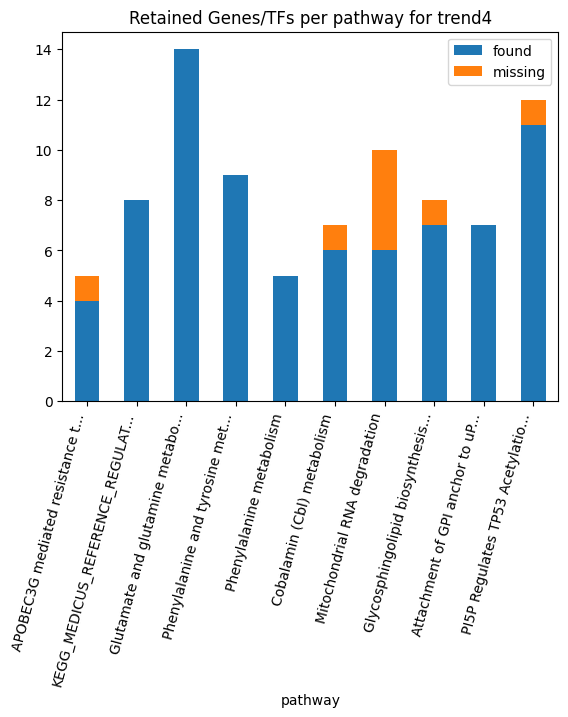

In [51]:
pwc = evaluate_communities_detail(dkg_filtered, dkgModules, "trend4", trend2gene, trend2pathways, pathways2genes, gene2type, fullKG=dkg)

In [42]:
dkg.kg.nodes["R-HSA-9759218"]

{'id': 'R-HSA-9759218',
 'type': {'geneset'},
 'name': 'Cobalamin (Cbl) metabolism',
 'score': 0.5237902307632696,
 'source': 'reactome',
 'fc': {'score': 1.8484971776679304, 'sig': 0.06508708231445828},
 'fc_score': 1.8484971776679304}

In [43]:
pd.set_option('display.max_rows', None)
display(simulatedGenes[simulatedGenes.trend=="trend4"].head(None))
pd.set_option('display.max_rows', 50)

,wildtype,stage1,stage2,stage3,geneset,trend,element_type,gene
334,1,2,2,8,KEGG_MEDICUS_REFERENCE_REGULATION_OF_GF_RTK_RA...,trend4,gene,ARAF
335,1,2,2,8,KEGG_MEDICUS_REFERENCE_REGULATION_OF_GF_RTK_RA...,trend4,gene,BRAF
336,1,2,2,8,KEGG_MEDICUS_REFERENCE_REGULATION_OF_GF_RTK_RA...,trend4,gene,MRAS
337,1,2,2,8,KEGG_MEDICUS_REFERENCE_REGULATION_OF_GF_RTK_RA...,trend4,gene,PPP1CA
338,1,2,2,8,KEGG_MEDICUS_REFERENCE_REGULATION_OF_GF_RTK_RA...,trend4,gene,PPP1CB
339,1,2,2,8,KEGG_MEDICUS_REFERENCE_REGULATION_OF_GF_RTK_RA...,trend4,gene,PPP1CC
340,1,2,2,8,KEGG_MEDICUS_REFERENCE_REGULATION_OF_GF_RTK_RA...,trend4,gene,RAF1
341,1,2,2,8,KEGG_MEDICUS_REFERENCE_REGULATION_OF_GF_RTK_RA...,trend4,gene,SHOC2
342,1,2,2,8,R-HSA-180689,trend4,gene,APOBEC3G
343,1,2,2,8,R-HSA-180689,trend4,gene,BANF1
